# Unsupervised learning model to select initial set

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

In [ ]:
TRAIN_PATH = "../data/randomsplit/train"
VAL_PATH = "../data/randomsplit/val"

In [4]:
def comp_ratio(dataset):
    ''' Compute anomaly ratio
    '''
    instance = dataset[(dataset['Label']==1)]
    rate=len(instance)/len(dataset)*100
    return round(rate,2), len(instance)

### Load data

In [ ]:
# float_number = '4903217' # high
float_number = '4903218' # low1
# float_number = '4903220' # low2
# float_number = '4903052' # low3
# float_number = '4903054' # low4

train_file = os.path.join(TRAIN_PATH, f'PR_PF_{float_number}.csv')
val_file = os.path.join(VAL_PATH, f'PR_PF_{float_number}.csv')

data_df = pd.read_csv(train_file)
val_data_df = pd.read_csv(val_file)

error_ratio, _ = comp_ratio(data_df)
error_ratio = error_ratio/100

error_ratio


0.0084

In [6]:
n_initial = 1000

In [7]:
# # Drop any columns that are not features
# X = data_df.drop(columns=['ID', 'Date', 'Label'])  # Replace 'label_column' with the actual label column name
# X_val = val_data_df.drop(columns=['ID', 'Date', 'Label'])

# # Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_val_scaled = scaler.fit_transform(X_val)

In [8]:
%load_ext autoreload
%autoreload 2
from visualization.tsne_visualization import Tsne
tsne = Tsne(float_number)
tsne_df = tsne.get_tsne_df()
tsne_df.head()

,feature1,feature2,Label
0,-15.853889,51.966827,0
1,-64.139732,-99.472466,0
2,-78.511032,-81.480827,0
3,-65.123306,-81.755081,0
4,-105.981903,-99.861252,0


In [9]:
# Drop any columns that are not features
X = tsne_df.drop(columns=['Label'])  # Replace 'label_column' with the actual label column name
y = tsne_df['Label']
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[0]

array([-0.24469447,  0.7537274 ], dtype=float32)

### LOF

In [10]:
# Specify the number of top k anomalous instances to select
# k = n_initial
k = 1000

# Fit the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=error_ratio, novelty=True)  # You can adjust parameters as needed
labels = lof.fit(X_scaled[:100000])

anomaly_scores = lof.negative_outlier_factor_
# labels = lof.fit_predict(X_val_scaled)

# Get the indices of the top k most anomalous instances
top_k_anomalies_indices = np.argsort(anomaly_scores)[:k]

# Select the top k most anomalous instances from the original DataFrame
lof_top_k_anomalies = data_df.iloc[top_k_anomalies_indices]

# print("Top {} most anomalous instances:".format(k))
lof_top_k_anomalies.Label.sum()

6

In [11]:
predictied_anomalies = tsne_df.iloc[top_k_anomalies_indices]
predictied_anomalies.head()

,feature1,feature2,Label
2111,-50.021984,-127.421524,1
26836,-37.421391,22.905344,0
61364,-2.858768,-81.872978,0
54912,-35.192650,12.069623,0
52074,-5.712987,-82.184792,0


-------- 4903218 --------


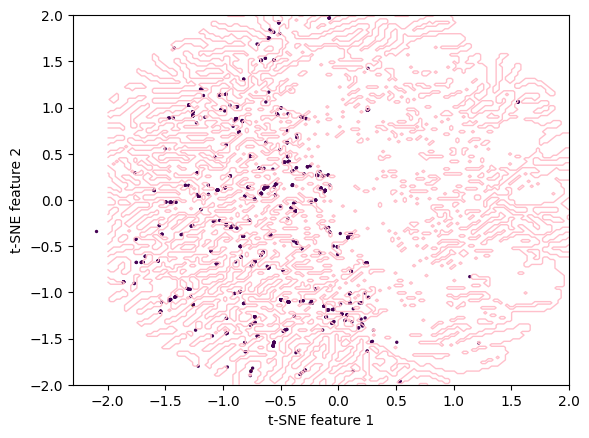

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax = tsne.visualize_from_prebuilt(top_k_anomalies_indices, ax)
xx, yy = np.meshgrid(np.linspace(-2, 2, 150), np.linspace(-2, 2, 150))
xx1 = scaler.fit_transform(xx)
yy1 = scaler.fit_transform(yy)
Z = lof.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=1, colors="pink")

### OCSVM

In [17]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

n_initial = 1000
# Load your dataset as a DataFrame
n_random = int(n_initial/2)
initial_set = tsne_df.sample(n=n_random, random_state=42)
unlabeled_set = tsne_df.drop(initial_set.index)

normal_data = initial_set[initial_set['Label']==0]

# Specify the number of top k anomalous instances to select
k = n_initial - n_random
# Drop any columns that are not features
X_norm = normal_data.drop(columns=['Label'])  # Replace 'label_column' with the actual label column name


# Standardize the features
scaler = StandardScaler()
X_norm_scaled = scaler.fit_transform(X_norm)

# Fit the OC-SVM model
ocsvm = OneClassSVM(nu=0.01, kernel='poly', gamma='scale')  # You can adjust parameters as needed
ocsvm.fit(X_norm_scaled)

Z = unlabeled_set.drop(columns=['Label'])

# Standardize the features
Z_scaled = scaler.fit_transform(Z)

# Predict anomaly scores for instances
distances = ocsvm.decision_function(Z_scaled)
labels = ocsvm.predict(Z_scaled)
# anomaly_scores = ocsvm.decision_function(X_val_scaled)

# Get the indices of the top k most anomalous instances
# top_k_anomalies_indices = anomaly_scores.argsort()[:k]
top_k_anomalies_indices = distances.argsort()[:k]

# Select the top k most anomalous instances from the original DataFrame
# ocsvm_top_k_anomalies = unlabeled_set.iloc[top_k_anomalies_indices]
ocsvm_top_k_anomalies = data_df.iloc[top_k_anomalies_indices]

# print("Top {} most anomalous instances:".format(k))
ocsvm_top_k_anomalies.Label.sum()


4

-------- 4903218 --------


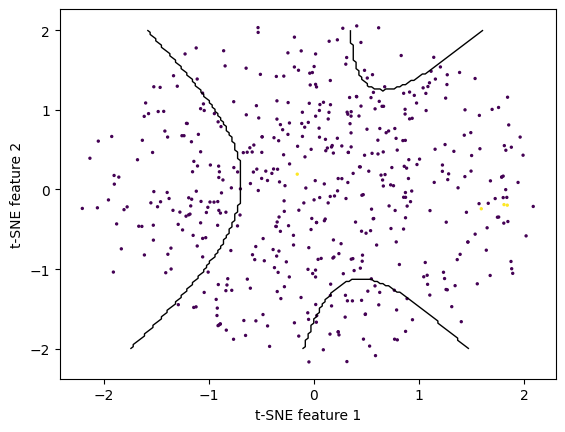

In [18]:
fig, ax = plt.subplots()
ax = tsne.visualize_from_prebuilt(top_k_anomalies_indices, ax)
xx, yy = np.meshgrid(np.linspace(-2, 2, 150), np.linspace(-2, 2, 150))
Z = ocsvm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=1, colors="black")

### iForest

In [63]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Specify the number of top k anomalous instances to select
k = n_initial

# Fit the Isolation Forest model
isoforest = IsolationForest(n_estimators=100, contamination=error_ratio)  # You can adjust parameters as needed
isoforest.fit(X_scaled)

# Predict anomaly scores (negative scores indicate anomalies)
# anomaly_scores = isoforest.decision_function(X_scaled)
anomaly_scores = isoforest.decision_function(X_scaled)

# Get the indices of the top k most anomalous instances
top_k_anomalies_indices = np.argsort(anomaly_scores)[:k]

# Select the top k most anomalous instances from the original DataFrame
top_k_anomalies = data_df.iloc[top_k_anomalies_indices]

# print("Top {} most anomalous instances:".format(k))
top_k_anomalies.Label.sum()

0